### Benötigte imports

In [1]:
import keras as keras
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.python.eager import context
from tensorflow.keras.utils import plot_model
from keras.models import clone_model
from keras.optimizers import Adam, SGD
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import random

2024-06-09 15:20:24.275221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Digit Recognition

### Erstellung des Modells

In [2]:
# initialisierung des Modells
untrained_model = Sequential()
untrained_model.add(Dense(600, activation='relu', input_shape=(784, ),name = "first_layer"))
untrained_model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
untrained_model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
untrained_model.add(Dense(10, activation = 'softmax', name = "output_layer"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Erstelltes Modell kompilieren

In [3]:
# kompilieren des Modells
model = clone_model(untrained_model)


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Einlesen der Trainingsdaten

In [4]:
import random
from keras.datasets import mnist
import sys

# Diese Methode ließt eine Anzahl von train_size Handgeschriebenen Ziffern zum Training und eine Anzahl von
# test_size Hangeschriebenen Ziffern zum Testen aus dem  mnist dataset in arrays und gibt die arrays zurück
import inspect
print(inspect.getsource(mnist.load_data))
def readData(train_size, test_size):
    # Lade den MNIST-Datensatz
    data=np.load("DigitRecognition/mnist.npz")
    x_train=data['x_train']
    y_train=data['y_train']
    x_test=data['x_test']
    y_test=data['y_test']
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Überprüfe, ob train_size oder test_size nicht größer als die Anzahl der Datensätze ist
    if train_size > len(x_train) :
        print("Fehler: train_size überschreitet Datenmenge von "+str(len(x_train)))
        sys.exit() 
    if test_size > len(x_test) :
        print("Fehler: test_size überschreitet Datenmenge von "+str(len(x_test)))
        sys.exit() 

    # Wähle zufällige Indizes für Trainingsdaten
    train_indices = random.sample(range(len(x_train)), train_size)
    # Wähle zufällige Indizes für Testdaten
    test_indices = random.sample(range(len(x_test)), test_size)
    
    # Extrahiere die ausgewählten Trainingsdaten und Testdaten
    train_data = x_train[train_indices].reshape(train_size, -1) / 255.0
    verify_train_data = y_train[train_indices]
    test_data = x_test[test_indices].reshape(test_size, -1) / 255.0
    verify_test_data = y_test[test_indices]

    return train_data, verify_train_data, test_data, verify_test_data

@keras_export("keras.datasets.mnist.load_data")
def load_data(path="mnist.npz"):
    """Loads the MNIST dataset.

    This is a dataset of 60,000 28x28 grayscale images of the 10 digits,
    along with a test set of 10,000 images.
    More info can be found at the
    [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

    Args:
        path: path where to cache the dataset locally
            (relative to `~/.keras/datasets`).

    Returns:
        Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

    **`x_train`**: `uint8` NumPy array of grayscale image data with shapes
      `(60000, 28, 28)`, containing the training data. Pixel values range
      from 0 to 255.

    **`y_train`**: `uint8` NumPy array of digit labels (integers in range 0-9)
      with shape `(60000,)` for the training data.

    **`x_test`**: `uint8` NumPy array of grayscale image data with shapes
      `(10000, 28, 28)`, containing the test data. Pixel values range
      from 0 to 255.

    **`y_tes

In [5]:
# importiere callback Klasse um benutzerdefinierte Aktionen während des Trainings des Modells durchführen zu können
from keras.callbacks import Callback

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        
        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)

# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)
    
    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model


In [6]:
# Einlesen der Trainingsdaten und Testdaten
train_length = 200
test_length = 10000
epoch=17
train_data, train_verification_data, test_data, test_verification_data = readData(train_length, test_length)

### Training des Modells

In [7]:
# Trainieren des Modells
train_losses, train_accuracies,test_losses, test_accuracies, model = train_and_get_metrics(model, train_data, train_verification_data, test_data, test_verification_data,  epochs=epoch, batch_size=128)

Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - accuracy: 0.1965 - loss: 2.2426
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6728 - loss: 1.7096
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8465 - loss: 1.1805
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step - accuracy: 0.9009 - loss: 0.7342
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9444 - loss: 0.4296
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9306 - loss: 0.2598
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9544 - loss: 0.1607
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9762 - loss: 0.1100
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9941 - loss: 0.0552
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9941 - loss: 0.0349
Epoch 11/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 1.0000 - loss: 0.0231
Epoch 12/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 1.0000 - lo

### Testen und plotten

In [8]:
# Konvertiert das 1D-Array in ein 2D-Array, das zum Plotten der Ziffer verwendet wird.
def to2DArray(vektor):
    matrix = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            matrix[i, j] = vektor[i*28 + j]
            
    return matrix

def predictAndPlotAndShowOutput(modell, testdaten, test_verifikationsdaten, label=False):
    ziffern_verfügbar = range(len(testdaten))
    ziffern_zum_plotten = np.random.choice(ziffern_verfügbar, size = 6, replace=False)
    if label:
        fig, ax = plt.subplots(3, 4, figsize=(12, 12))
    else:
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    for j in range(3):
        for i in range(2):
            vorhersage = modell.predict(np.array([testdaten[ziffern_zum_plotten[j*2+i]]]))
            geratene_ziffer = np.argmax(vorhersage)
            confidence = np.max(vorhersage)
            ax[j, 2*i].imshow(to2DArray(testdaten[ziffern_zum_plotten[j*2+i]]), cmap='gray', interpolation='none')
            #+ ", confidence: " +str(round(confidence,3)))
            ax[j, 2*i].axes.get_xaxis().set_visible(False)
            ax[j, 2*i].axes.get_yaxis().set_visible(False)
            ax[j, 2*i+1].bar(np.arange(10), vorhersage[0], color = 'navy')
            
            ax[j, 2*i+1].set_ylabel("Probability")
            ax[j, 2*i+1].set_ylim(0,1)
            ax[j, 2*i+1].set_title("Output")

            if label:
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xticklabels(label,rotation = 75)
                ax[j, 2*i].set_title("Prediction: "+label[geratene_ziffer])
            else:
                ax[j, 2*i].set_title("Prediction: "+str(geratene_ziffer))
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xlabel("Digit")
    if label:
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

  
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)
    
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


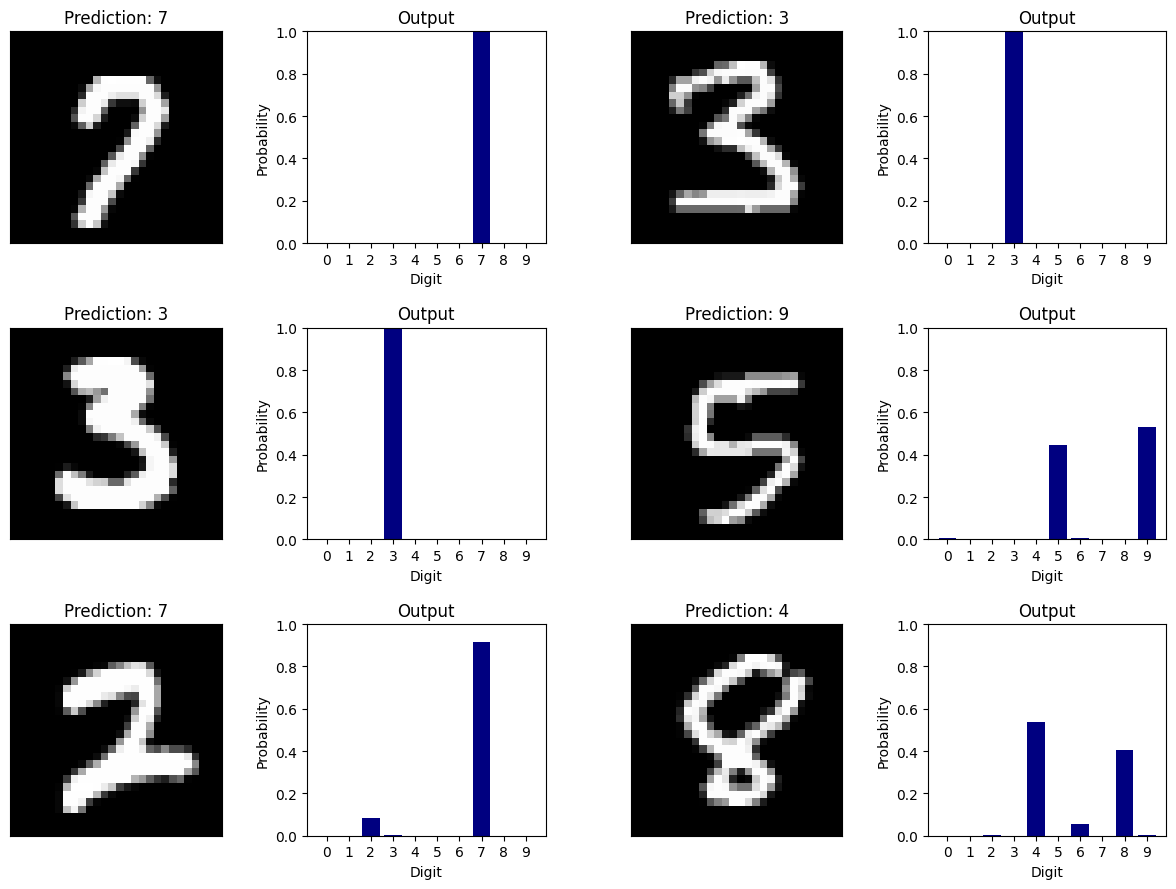

In [9]:
predictAndPlotAndShowOutput(model, test_data, test_verification_data)

### Trainingsverlauf

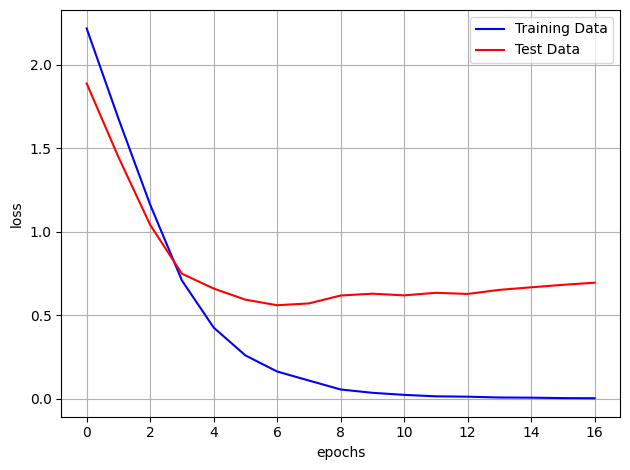

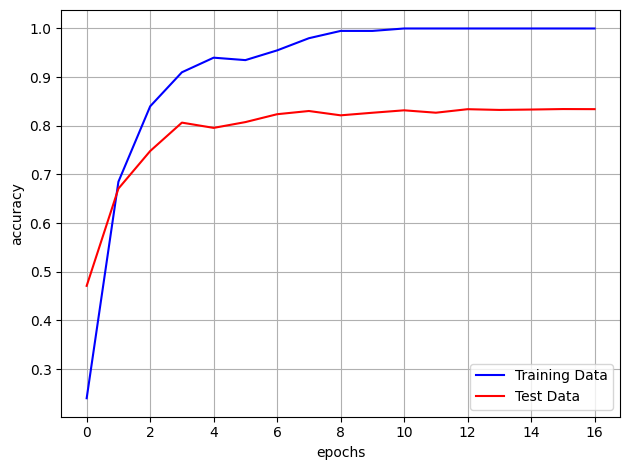

In [10]:
# plotten
epochs = np.arange(epoch)
plt.plot(epochs, train_losses, label = 'Training Data', color ='blue')
plt.plot(epochs, test_losses, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies, label = 'Training Data', color ='blue')
plt.plot(epochs, test_accuracies, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Fashion Recognition

### Daten Laden

In [11]:
def load_mnist(kind='train', model_type ='convolutional'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

### Lade Fashion Daten

In [12]:
x_train_full_connected, y_train_full_connected = load_mnist(kind='MNISTFashion/train', model_type ='fully_connected')
x_test_full_connected, y_test_full_connected = load_mnist(kind='MNISTFashion/t10k', model_type ='fully_connected')
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)

### Neues Modell erstellen (clonen) und trainieren

In [13]:
modelFullyConnected = clone_model(untrained_model)
optimizer = Adam(learning_rate=0.001)
modelFullyConnected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_con, test_losses_fully_con, test_accuracies_fully_con, modelFullyConnected = train_and_get_metrics(modelFullyConnected, x_train_full_connected[:200], y_train_full_connected[:200], x_test_full_connected, y_test_full_connected,  epochs=17,  batch_size=128)

Epoch 1/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - accuracy: 0.0804 - loss: 145.6853
Epoch 2/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.2433 - loss: 87.7069
Epoch 3/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2678 - loss: 59.4228
Epoch 4/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 0.4877 - loss: 30.9644
Epoch 5/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6855 - loss: 13.9217
Epoch 6/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.6435 - loss: 14.4172
Epoch 7/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7811 - loss: 6.1506
Epoch 8/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7218 - loss: 6.7935
Epoch 9/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7885 - loss: 6.6228
Epoch 10/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7997 - loss: 4.9719
Epoch 11/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8605 - loss: 3.1240
Epoch 12/17
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.89

### Teste und plotte

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_26871/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]
/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_26871/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]
/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_26871/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_26871/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]
/var/folders/22/p3t1mllj1gg156gy7k3fzpnh0000gn/T/ipykernel_26871/2488668663.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i, j] = vektor[i*28 + j]


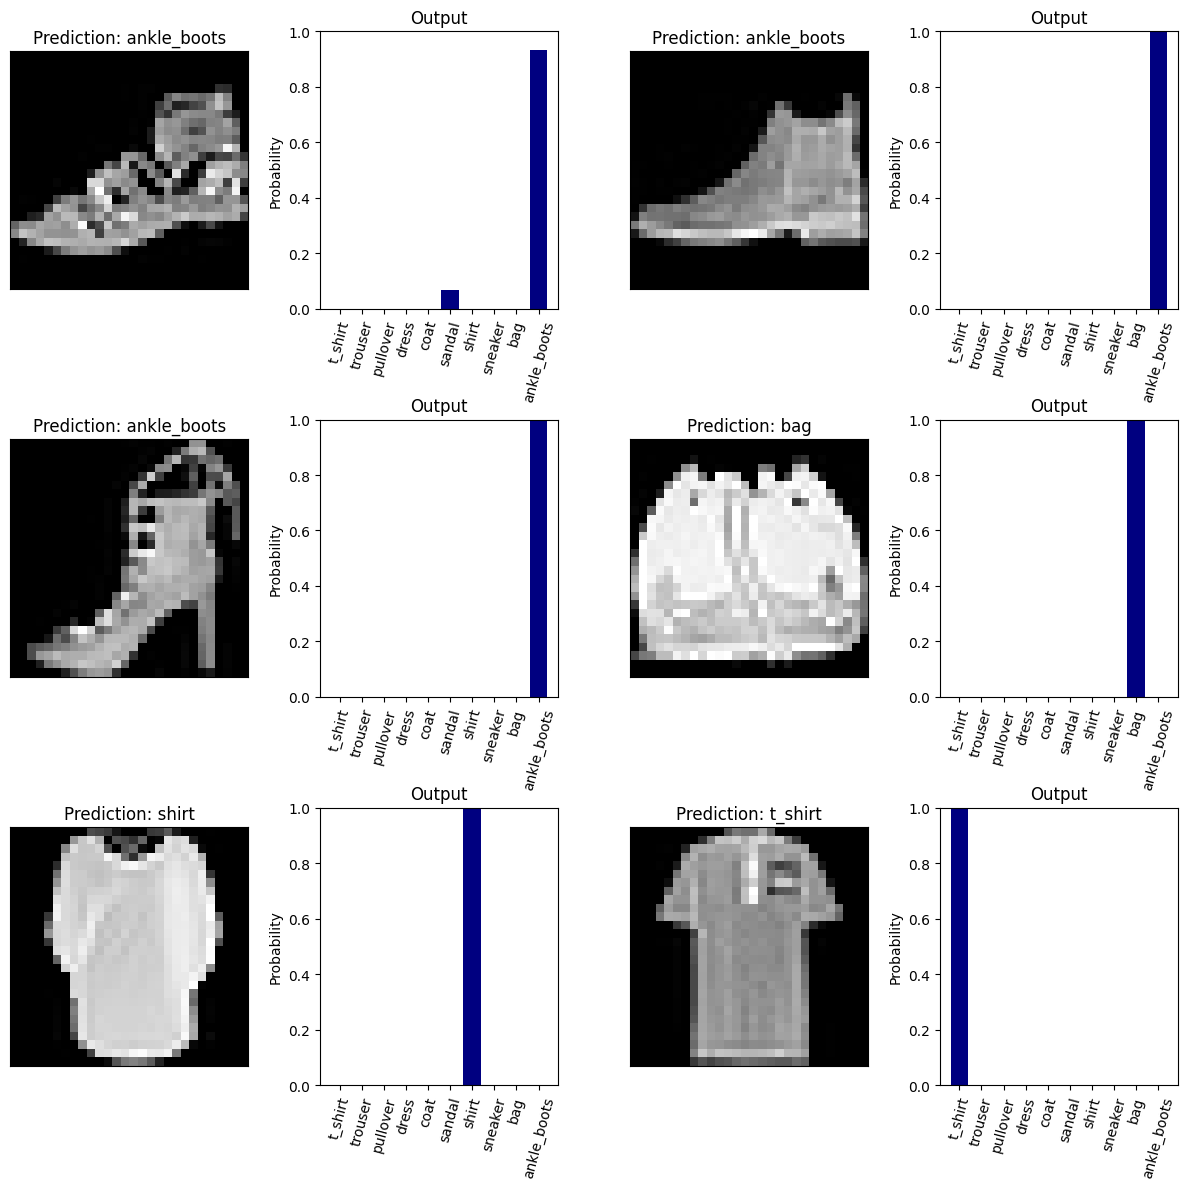

In [14]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
predictAndPlotAndShowOutput(modelFullyConnected, x_test_full_connected, y_test_full_connected, LABEL_NAMES)

### Trainingsverlauf

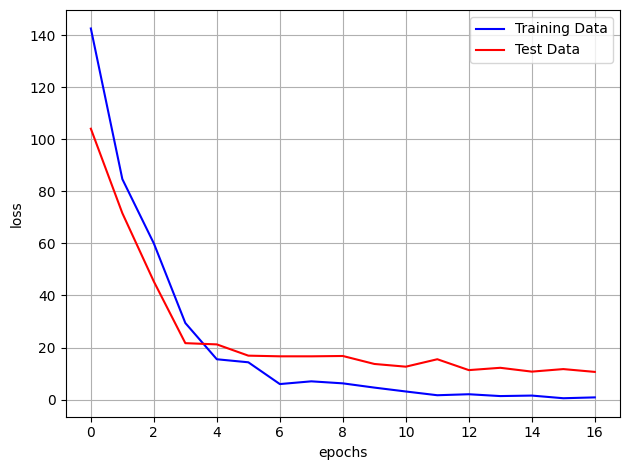

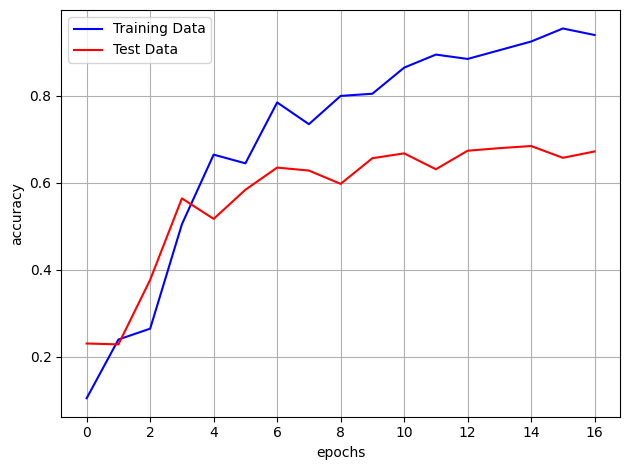

In [15]:
# plotten
epochs = np.arange(epoch)
plt.plot(epochs, train_losses_fully_con, label = 'Training Data', color ='blue')
plt.plot(epochs, test_losses_fully_con, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies_fully_con, label = 'Training Data', color ='blue')
plt.plot(epochs, test_accuracies_fully_con, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()